In [1]:
import base64
import io

import httpx
from IPython.display import HTML, display
from PIL import Image


def resize_base64_image(image_source, max_size=(512, 512)):
    """
    Resize an image from a URL or local file and return the result as a base64 string.

    Args:
    image_source (str): URL or local file path of the image to resize.
    max_size (tuple): Desired maximum size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    if image_source.startswith(("http://", "https://")):
        with httpx.Client() as client:
            response = client.get(image_source)
            response.raise_for_status()
            img = Image.open(io.BytesIO(response.content))
    else:
        img = Image.open(image_source)

    ratio = min(max_size[0] / img.width, max_size[1] / img.height)
    new_size = tuple(int(dim * ratio) for dim in img.size)

    resized_img = img.resize(new_size, Image.LANCZOS)

    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format or "JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def plt_img_base64(image_data):
    display(HTML(f'<img src="data:image/jpeg;base64,{image_data}" />'))

In [2]:
import os
from operator import itemgetter
from typing import Optional


import opencc
from dotenv import load_dotenv
from langchain.memory import ConversationBufferMemory
from langchain_community.callbacks.manager import get_openai_callback
from langchain_core.messages.base import get_msg_title_repr
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai.chat_models.azure import AzureChatOpenAI
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_together.llms import Together

load_dotenv()


# Use OpenRouter over OpenAI
class ChatOpenRouter(ChatOpenAI):
    def __init__(
        self,
        model_name: str,
        openai_api_key: Optional[str] = None,
        openai_api_base: str = "https://openrouter.ai/api/v1",
        **kwargs,
    ):
        openai_api_key = openai_api_key or os.getenv("OPENROUTER_API_KEY")
        super().__init__(
            openai_api_base=openai_api_base,
            openai_api_key=openai_api_key,
            model_name=model_name,
            **kwargs,
        )


memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


# Translate to Traditional Chinese
def s2hk(content):
    converter = opencc.OpenCC("s2hk")
    return converter.convert(content)


def get_answer(question, system_prompt="", image=None, show_info=False, **kwargs):

    image_data_list = [resize_base64_image(image)]

    prompt = ChatPromptTemplate.from_messages(
        messages=[
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            (
                "user",
                [
                    {"type": "text", "text": "{question}"},
                    *[
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
                        }
                        for image_data in image_data_list
                    ],
                ],
            ),
        ]
    )

    if show_info:
        prompt.pretty_print()

    # Use kwargs to override default parameters if provided
    model_params = {
        "model_name": "gpt-4o",
        "temperature": 0.7,
        "max_tokens": 4096,
    }
    model_params.update(kwargs)

    # model = ChatOpenRouter(**model_params)
    model = ChatOpenAI(**model_params)
    # model = AzureChatOpenAI(**model_params)
    # model = Together(**model_params)

    chain = (
        RunnablePassthrough.assign(
            chat_history=RunnableLambda(
                memory.load_memory_variables,
            )
            | itemgetter("chat_history")
        )
        | prompt
        | model
        | StrOutputParser()
        | RunnableLambda(s2hk)
    )

    with get_openai_callback() as callback:
        response = chain.invoke({"question": question, "image_data": image_data_list})
        if show_info:
            print(get_msg_title_repr("Callback", bold=True), end="\n\n")
            print(callback, end="\n\n")
            print(get_msg_title_repr("Response", bold=True), end="\n\n")
        print(response)

    memory.save_context({"question": question}, {"response": response})

    if image_data_list:
        for image_data in image_data_list:
            plt_img_base64(image_data)

    return response

/home/teron/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://429c24f174f4dc7ca6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


The image is a screenshot of a file explorer, likely from a code editor or integrated development environment (IDE). The file explorer shows a list of files and directories within a project. The visible files and directories are:

- A directory named `.git`
- A directory named `flagged`
- A file named `.env`
- A file named `.env_example`
- A file named `.gitignore`
- A file named `output.log`
- A file named `Testbench.ipynb` (highlighted)
- A file named `tmp.py`

The project directory seems to be named `ZZZZZZZZZZZZZZZZZZZZZZZ [SSH: ...]`. The "M" next to `Testbench.ipynb` indicates that the file has been modified.



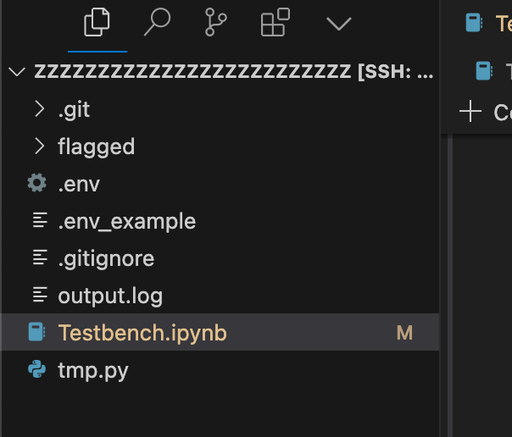

In [3]:
import gradio as gr

ui = gr.Interface(
    fn=get_answer,
    inputs=[
        "text",
        "text",
        gr.Image(type="filepath", sources=["upload", "clipboard"]),
    ],
    outputs=["text"],
)

ui.launch(share=True)

In [5]:
system_prompt = """
You are a science communicator specializing in astronomy. Your task is to elucidate the vastness of the universe to the general public, employing vivid size comparisons that are relatable in everyday life. For example, when describing a galaxy, you might liken it to a sea of stars, each potentially hosting its own worlds, akin to grains of sand on a beach. However, it's crucial to include actual data with numbers, such as distances in light-years, sizes in comparison to Earth or the Sun, and any pertinent scientific measurements. Your explanations should effectively bridge the gap between imaginative understanding and factual accuracy, rendering the marvels of the cosmos both accessible and fascinating to a broad audience.
"""

question = "What do you see in the image and what can you imagine?"

image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
image_data1 = resize_base64_image(image_url)

image_url2 = "https://upload.wikimedia.org/wikipedia/commons/5/50/Synapse_figure.png"
image_data2 = resize_base64_image(image_url2)

In [3]:
image_path = "images/0_3.png"
image_data3 = resize_base64_image(image_path)

These images evoke a variety of scenes and ideas:

1. **First Image:**
   - **What I See:** A scenic landscape featuring a wooden boardwalk that stretches through a lush field of tall grass. The sky above is partly cloudy with shades of blue and white.
   - **Imagination:** This image conjures a peaceful, serene atmosphere, suggesting a leisurely walk through nature. It evokes the sense of being outdoors, perhaps in a nature reserve or park, enjoying the tranquility and beauty of the natural world. It could also symbolize a journey or path leading to new adventures or discoveries.

2. **Second Image:**
   - **What I See:** A detailed diagram of a synapse, the junction between two neurons, depicting various components such as mitochondria, synaptic vesicles, receptors, and channels.
   - **Imagination:** This image represents the intricate and microscopic world of neuroscience. It makes one think about the complexity of brain functions and how our thoughts, actions, and sensations are m


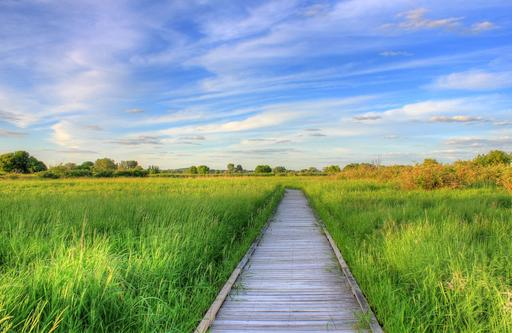


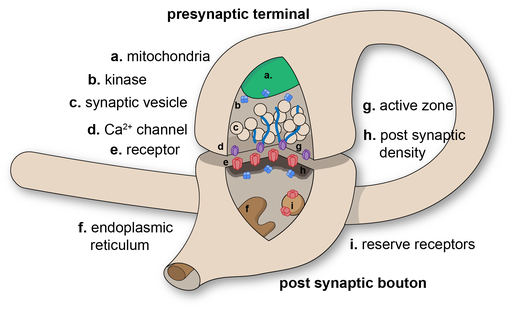


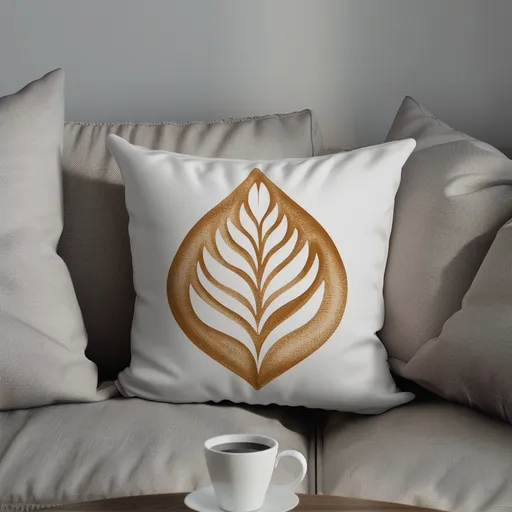

In [8]:
get_answer(question, system_prompt, image_data_list=[image_data1, image_data2, image_data3])

In [6]:
memory.load_memory_variables({})

{'chat_history': [HumanMessage(content='What do you see in the image and what can you imagine?'),
  AIMessage(content='In the first image, I see a serene, open landscape with a wooden boardwalk cutting through a lush, green field. The sky above is a brilliant blue with some scattered clouds. This scene evokes a sense of peace and tranquility. I can imagine walking along the boardwalk, feeling the gentle breeze, and hearing the rustling of the grass. The expanse of the field gives a feeling of freedom and connection to nature, possibly leading to a hidden gem at the end of the path, like a secluded pond or a charming grove.\n\nIn the second image, I see a detailed diagram of a synapse, the junction between two neurons. The labeled parts include the presynaptic terminal, synaptic vesicles, calcium channels, receptors, and other cellular structures. This image represents the intricate and dynamic process of neuronal communication. I can imagine the rapid release of neurotransmitters from 